In [1]:
import numpy as np
import PIL
import torch
from torchvision import datasets, transforms

In [2]:
def mse(x,y):
    return np.sum((x-y)**2, axis=-1)

# image: (SIZE, SIZE, C)
# candidates: (N, TILE_SIZE, TILE_SIZE, C)
def create_metaphoto(image, candidates, loss_fn=mse, k=10, with_replacement=True):
    NUM_CANDIDATES, TILE_SIZE, _, _ = candidates.shape
    IMAGE_SIZE, _, CHANNELS = image.shape
    TILES_PER_DIM = IMAGE_SIZE // TILE_SIZE
    TOTAL_TILES = TILES_PER_DIM * TILES_PER_DIM


    # breaks image into TILES_PER_DIM x TILES_PER_DIM grid of subimages
    grid = image.reshape(TILES_PER_DIM, TILE_SIZE, TILES_PER_DIM, TILE_SIZE, CHANNELS).swapaxes(1, 2)

    # flattens grid into sequence of subimages
    grid = grid.reshape(-1, *grid.shape[2:])

    # for broadcasting to work with the following line
    grid = np.expand_dims(grid, axis=1)

    # loss = (grid - candidates)**2
    loss = loss_fn(grid, candidates)

    # flatten the differences into single dimension per image
    loss = loss.reshape(*loss.shape[:2], -1)

    total_loss = np.sum(loss, axis=-1)

    if(with_replacement):
        best = np.argmin(total_loss, axis=-1)
        best_k = np.argpartition(total_loss, k, axis=-1)[:,:k]
        chosen_imgs = np.random.randint(0, k, size=best_k.shape[0])
        best = best_k[np.arange(best_k.shape[0]),chosen_imgs]

    else:
        # iterate over tiles in random order, pick best image that hasnt been used yet
        # otherwise images near the bottom will be bad
        assert TOTAL_TILES <= NUM_CANDIDATES
        sorted_candidates = np.argsort(total_loss, axis=-1)
        is_img_unused = np.ones(NUM_CANDIDATES, dtype=np.int32)
        best = np.ones(sorted_candidates.shape[0], dtype=np.int32)
        for i in np.random.permutation(sorted_candidates.shape[0]):
            row = sorted_candidates[i]
            min_unused_idx = row[np.argmax(is_img_unused[row])]
            is_img_unused[min_unused_idx] = 0
            best[i] = min_unused_idx

    # get best tiles and reshape back TILES_PER_DIM x TILES_PER_DIM grid of subimages
    tiles = candidates[best]
    tiles = tiles.reshape(TILES_PER_DIM, TILES_PER_DIM, *tiles.shape[1:])

    # consolidate grid of subimages into full image
    metaphoto = tiles.swapaxes(1, 2).reshape(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    return metaphoto

In [3]:
IMAGE_SIZE = 800
TILE_SIZE = 25
CANDIDATES = 1050

transform_main = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

transform_candidates = transforms.Compose([
    transforms.Resize(TILE_SIZE),
    transforms.ToTensor(),
])

I_HAVE_THE_DATASET = True
dataset_main = datasets.Places365(root='./data', split='val', transform=transform_main, small=True, download=not I_HAVE_THE_DATASET)
dataset_candidates = datasets.Places365(root='./data', split='val', transform=transform_candidates, small=True, download=not I_HAVE_THE_DATASET)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
target_img_path = '/content/drive/MyDrive/Colab Notebooks/koalas.jpg'
example = transform_main(PIL.Image.open(target_img_path))
example = example.permute(1, 2, 0).numpy()
example = example[:,:,:3]

candidates: torch.Tensor = next(iter(torch.utils.data.DataLoader(dataset_candidates, batch_size=CANDIDATES, shuffle=True)))[0]
candidates = candidates.permute(0, 2, 3, 1).numpy()

metaphoto = create_metaphoto(example, candidates, with_replacement=False)

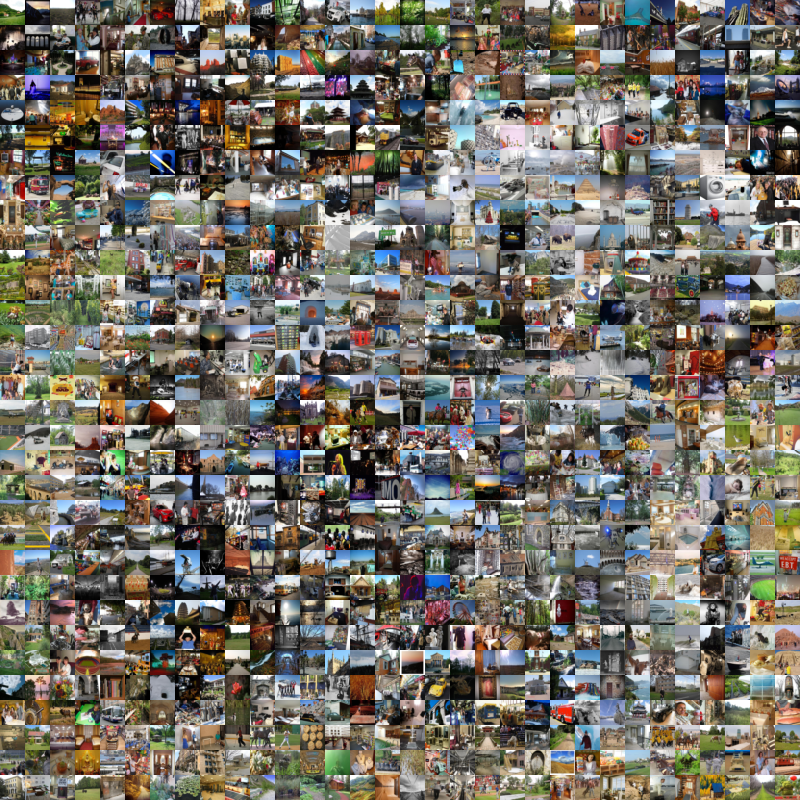

In [10]:
pre = transforms.ToPILImage()(torch.from_numpy(example).permute(2, 0, 1))
post =transforms.ToPILImage()(torch.from_numpy(metaphoto).permute(2, 0, 1))
pre
post